## Lending Club Case Study

### Import all required libraries

In [29]:
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load the data

In [30]:
file_path = "C:\MS\Course\Case Study Lending Club\loan\loan.csv"
df = pd.read_csv(file_path)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [31]:
df.shape

(39717, 111)

# Data Understanding

#### Drop customer/loan behaviour/process features
#### Drop features which does not directly relate to the objective of the study e.g. last_pymnt_amnt, delinq_amnt, issue_d etc
#### 'loan_amnt', 'funded_amnt' features will also be dropped. Study will take 'funded_amnt_inv' into consideration and rename it as 'loan_amnt'

In [32]:
behaviour_variables = ['loan_amnt', 'funded_amnt', "delinq_2yrs", "earliest_cr_line", "inq_last_6mths", "open_acc", "pub_rec", 
                       "revol_bal", "revol_util", "total_acc", "out_prncp", "out_prncp_inv", 
                       "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", 
                       "total_rec_late_fee", "recoveries", "collection_recovery_fee", "last_pymnt_d", 
                       "last_pymnt_amnt", "last_credit_pull_d", "application_type", "delinq_amnt", "desc", "title"]
    
cleaned_df = df.drop(behaviour_variables, axis=1)

cleaned_df.rename(columns = {'funded_amnt_inv':'loan_amnt'}, inplace = True)

#### Some features like url, id, zip_code are not required for analysis as they do not have any impact on the loan status
#### Other features like initial_list_status, acc_now_delinq, delinq_amnt, policy_code have single value, so they are not useful, hence they will also be dropped.

In [33]:
other_extra_variables = ["url", "id", "emp_title", "zip_code", "initial_list_status", "acc_now_delinq", "policy_code", "collections_12_mths_ex_med", "chargeoff_within_12_mths", "tax_liens", "pymnt_plan"]

cleaned_df = cleaned_df.drop(other_extra_variables, axis=1)

# Data Cleaning

#### Remove all variables which has more than 75% null values.
- 54 Features have 100% null values.
- 2 Features have more than 75% null values.

#### Remove all records with LOAN_STATUS as `Current` since we are focusing on `Fully paid` and `Charged off`

In [34]:
null_percent = 75
null_count = int(((100 - null_percent) / 100) * df.shape[0] + 1)
# axis=1 => columns
# thresh => Delete columns which contains less than minimum thresh number of non-null values.
cleaned_df = cleaned_df.dropna(axis=1, thresh=null_count)

# Remove Current loan_status 
filtered_df = cleaned_df[cleaned_df["loan_status"] != "Current"]

filtered_df.shape

(38577, 18)

# Data Manipulation / Imputation

In [35]:
print('Number of Null in mths_since_last_delinq: ', filtered_df["mths_since_last_delinq"].isnull().sum())
print('Number of Null in pub_rec_bankruptcies: ', filtered_df["pub_rec_bankruptcies"].isnull().sum())

Number of Null in mths_since_last_delinq:  24905
Number of Null in pub_rec_bankruptcies:  697


It is safe to assume that both of the above features wherever they have null values, do not have any deliquencey or bankrupcy reported. Hence replacing their number values to 0 and also converting them to int type.

In [36]:
filtered_df["mths_since_last_delinq"].fillna(0, inplace = True)
filtered_df["mths_since_last_delinq"] = filtered_df["mths_since_last_delinq"].astype(int)

filtered_df["pub_rec_bankruptcies"].fillna(0, inplace = True)
filtered_df["pub_rec_bankruptcies"] = filtered_df["pub_rec_bankruptcies"].astype(int)

In [37]:
percent_missing = filtered_df.isnull().sum() * 100 / len(filtered_df)
percent_missing

member_id                 0.000000
loan_amnt                 0.000000
term                      0.000000
int_rate                  0.000000
installment               0.000000
grade                     0.000000
sub_grade                 0.000000
emp_length                2.677761
home_ownership            0.000000
annual_inc                0.000000
verification_status       0.000000
issue_d                   0.000000
loan_status               0.000000
purpose                   0.000000
addr_state                0.000000
dti                       0.000000
mths_since_last_delinq    0.000000
pub_rec_bankruptcies      0.000000
dtype: float64

#### To impute missing values, we an use
#### 1. `median` for emp_length
#### 2. `mod` for pub_rec_bankruptcies

In [38]:
filtered_df.shape

(38577, 18)

## Data Transformation
#### i) Check if loan_amnt is numeric
#### ii) Check if annual_inc is numeric
#### iii) Check if member_id is numeric and unique

In [39]:
print("loan_amnt - is numeric - ", is_numeric_dtype(filtered_df["loan_amnt"]), 
      "\nannual_inc - is numeric - ", is_numeric_dtype(filtered_df["annual_inc"]),
      "\nmember_id - is numeric - ", is_numeric_dtype(filtered_df["member_id"]), 
      "\nmember_id - is unique - ", filtered_df["member_id"].is_unique)

# Use 'df[variable].astype(dtype)' to cast if required

loan_amnt - is numeric -  True 
annual_inc - is numeric -  True 
member_id - is numeric -  True 
member_id - is unique -  True


#### iv) Remove % from int_rate
#### v) Extract only numbers from emp_length
#### vi) Extract year from issue_year
#### vii) Transform loan_status values to 0 / 1

In [40]:
# Remove % from int_rate 
filtered_df["int_rate"] = filtered_df["int_rate"].str.replace("%", "", regex=True).astype('float')

# Extract only integer from emp_length
filtered_df["emp_length"] = filtered_df.emp_length.str.extract('(\d+)')

# Extract only year from issue_d
filtered_df["issue_year"] = filtered_df.issue_d.str.extract('(\d+)')

# Transform loan_status values to 0 / 1 => Fully Pain = 1, Charged off = 0
filtered_df['loan_status'] = np.where(filtered_df['loan_status'] == "Fully Paid", 1, 0)

In [41]:
# Check distinct vaues for term
filtered_df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [42]:
# Remove space
filtered_df['term'] = filtered_df.term.str.strip()

In [43]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   member_id               38577 non-null  int64  
 1   loan_amnt               38577 non-null  float64
 2   term                    38577 non-null  object 
 3   int_rate                38577 non-null  float64
 4   installment             38577 non-null  float64
 5   grade                   38577 non-null  object 
 6   sub_grade               38577 non-null  object 
 7   emp_length              37544 non-null  object 
 8   home_ownership          38577 non-null  object 
 9   annual_inc              38577 non-null  float64
 10  verification_status     38577 non-null  object 
 11  issue_d                 38577 non-null  object 
 12  loan_status             38577 non-null  int32  
 13  purpose                 38577 non-null  object 
 14  addr_state              38577 non-null

In [44]:
filtered_df.shape

(38577, 19)

## Create bins for int_rate, annual_income and loan_amnt to calculate percentages
#### Used pandas qcut(quantile cut) library to segregate a range of values to a specific bin

In [45]:
print(filtered_df.int_rate.min())
print(filtered_df.int_rate.max())

5.42
24.4


In [46]:
pd.qcut(filtered_df.int_rate, q=5) # q is number of bins

0          (7.9, 10.99]
1         (15.21, 24.4]
2         (15.21, 24.4]
3        (12.84, 15.21]
5          (5.419, 7.9]
              ...      
39712      (7.9, 10.99]
39713      (7.9, 10.99]
39714      (7.9, 10.99]
39715      (5.419, 7.9]
39716    (12.84, 15.21]
Name: int_rate, Length: 38577, dtype: category
Categories (5, interval[float64, right]): [(5.419, 7.9] < (7.9, 10.99] < (10.99, 12.84] < (12.84, 15.21] < (15.21, 24.4]]

In [47]:
# Get Categories from above qcut and assign them as labels
filtered_df["int_rate_range"] = pd.qcut(filtered_df.int_rate, q=5, 
                                        labels=["5.4-7.9", "7.9-10.9", "10.9-12.8", "12.8-15.2", "15.2-24.4"])

In [48]:
print(filtered_df.annual_inc.min())
print(filtered_df.annual_inc.max())

4000.0
6000000.0


In [49]:
pd.qcut(filtered_df.annual_inc, q=5) # q is number of bins

0        (3999.999, 37196.16]
1        (3999.999, 37196.16]
2        (3999.999, 37196.16]
3         (37196.16, 50004.0]
5        (3999.999, 37196.16]
                 ...         
39712    (90000.0, 6000000.0]
39713    (3999.999, 37196.16]
39714    (90000.0, 6000000.0]
39715    (90000.0, 6000000.0]
39716    (3999.999, 37196.16]
Name: annual_inc, Length: 38577, dtype: category
Categories (5, interval[float64, right]): [(3999.999, 37196.16] < (37196.16, 50004.0] < (50004.0, 65004.0] < (65004.0, 90000.0] < (90000.0, 6000000.0]]

In [50]:
# Get Categories from above qcut and assign them as labels
filtered_df["annual_inc_range"] = pd.qcut(filtered_df.annual_inc, q=5, 
                                        labels=["4000-37196", "37196-50004", "50004-65004", "65004-90000", "90000-6000000"])

In [51]:
print(filtered_df.loan_amnt.min())
print(filtered_df.loan_amnt.max())

0.0
35000.0


In [52]:
pd.qcut(filtered_df.loan_amnt, q=5) # q is number of bins

0         (4375.0, 7000.0]
1         (-0.001, 4375.0]
2         (-0.001, 4375.0]
3        (7000.0, 10000.0]
5         (4375.0, 7000.0]
               ...        
39712     (-0.001, 4375.0]
39713     (-0.001, 4375.0]
39714     (-0.001, 4375.0]
39715     (-0.001, 4375.0]
39716     (-0.001, 4375.0]
Name: loan_amnt, Length: 38577, dtype: category
Categories (5, interval[float64, right]): [(-0.001, 4375.0] < (4375.0, 7000.0] < (7000.0, 10000.0] < (10000.0, 15000.0] < (15000.0, 35000.0]]

In [53]:
# Get Categories from above qcut and assign them as labels
filtered_df["loan_amnt_range"] = pd.qcut(filtered_df.loan_amnt, q=5, 
                                        labels=["500-5000", "5000-7750", "7750-11200", "11200-16000", "16000-35000"])

### Calculate percentage for variables which are required for analysis

In [54]:
def calculate_charged_off_percentage(filtered_df, col_name):
    """
    Calculate charged off percentage for a list of columns
    :param filtered_df: input dataframe
    :param col_name: column name for which percentage need to be calculated
    :return filtered_df: dataframe with new columns
    """
    # charged_off_perc = (total row count for col_name with loan_status=charged_off *100)/(total row count for col_name)
    total_col_cnt = filtered_df.groupby(by=[col_name])[col_name].count()
    charged_off_cnt = filtered_df[filtered_df["loan_status"] == 0].groupby(by=[col_name])[col_name].count()
    
    data = {"total_cnt": total_col_cnt, "charged_off_cnt": charged_off_cnt}
    col_df = pd.concat(data, axis = 1) # Create a new dataframe   
    new_col_name = col_name+"_chargedoff_perc"
    col_df[new_col_name] = (col_df.charged_off_cnt*100)/col_df.total_cnt
    col_df = col_df.sort_values(new_col_name, ascending=False).drop(["total_cnt", "charged_off_cnt"], axis=1)
    
    filtered_df = filtered_df.join(col_df, on=[col_name]) # Join new dataframe to filtered_df
    return filtered_df

In [55]:
col_list_for_analysis = ["term", "home_ownership", "emp_length", "addr_state", "grade", "purpose", 
                         "issue_year", "pub_rec_bankruptcies", "loan_amnt_range", "annual_inc_range", 
                         "int_rate_range", "verification_status"]
for col_name in col_list_for_analysis:
    filtered_df = calculate_charged_off_percentage(filtered_df, col_name)

## Data Analysis / Observations

In [56]:
filtered_df.dtypes

member_id                                  int64
loan_amnt                                float64
term                                      object
int_rate                                 float64
installment                              float64
grade                                     object
sub_grade                                 object
emp_length                                object
home_ownership                            object
annual_inc                               float64
verification_status                       object
issue_d                                   object
loan_status                                int32
purpose                                   object
addr_state                                object
dti                                      float64
mths_since_last_delinq                     int32
pub_rec_bankruptcies                       int32
issue_year                                object
int_rate_range                          category
annual_inc_range    

# Variable Segmentation
### Ordered Catagorical Variables
    loan_amnt
    int_rate
    grade
    sub_grade
    emp_length
    home_ownership
    annual_inc
    dti
    delinq_2yrs
    mths_since_last_delinq
    pub_rec_bankrupcies

### Unordered Categorical Variables
    term
    purpose
    addr_state
    verification_status

### Quantitative Variables
    loan_amnt
    int_rate
    installment
    annual_inc
    dti
    delinq_2yrs
    mths_since_last_delinq
    pub_rec_bankruptcies

### Quantitative Analysis

In [57]:
filtered_df.describe()

,member_id,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,mths_since_last_delinq,pub_rec_bankruptcies,term_chargedoff_perc,...,emp_length_chargedoff_perc,addr_state_chargedoff_perc,grade_chargedoff_perc,purpose_chargedoff_perc,issue_year_chargedoff_perc,pub_rec_bankruptcies_chargedoff_perc,loan_amnt_range_chargedoff_perc,annual_inc_range_chargedoff_perc,int_rate_range_chargedoff_perc,verification_status_chargedoff_perc
count,3.857700e+04,38577.000000,38577.000000,38577.000000,3.857700e+04,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,...,37544.000000,38560.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000,38577.000000
mean,8.422843e+05,10222.481123,11.932219,322.466318,6.877797e+04,0.854136,13.272727,12.717059,0.042694,14.586412,...,14.380460,14.592842,14.586412,14.586412,14.586412,14.586412,14.586412,14.586412,14.586412,14.586412
std,2.644519e+05,7022.720644,3.691327,208.639215,6.421868e+04,0.352975,6.673044,21.600187,0.202809,6.123638,...,0.850212,2.248779,7.146131,3.498377,1.538997,1.662102,1.986338,2.487629,7.064515,1.703538
min,7.069900e+04,0.000000,5.420000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,11.090872,...,12.887439,5.000000,5.993031,10.325581,12.595420,14.238527,12.843235,10.928524,5.353800,12.830957
25%,6.611310e+05,5000.000000,8.940000,165.740000,4.000000e+04,1.000000,8.130000,0.000000,0.000000,11.090872,...,13.833500,12.929145,5.993031,12.069565,12.877211,14.238527,13.069358,12.965065,10.287571,12.830957
50%,8.392920e+05,8733.440000,11.710000,277.860000,5.886800e+04,1.000000,13.370000,0.000000,0.000000,11.090872,...,14.263384,14.487633,12.205567,15.325395,15.870540,14.238527,13.771826,14.962886,14.699524,14.818642
75%,1.037336e+06,14000.000000,14.380000,425.550000,8.200000e+04,1.000000,18.560000,21.000000,0.000000,11.090872,...,15.371128,16.189380,17.194281,15.325395,15.870540,14.238527,15.120498,15.692585,17.161932,16.803212
max,1.314167e+06,35000.000000,24.400000,1305.190000,6.000000e+06,1.000000,29.990000,120.000000,2.000000,25.313785,...,15.680961,60.000000,33.779264,27.080958,17.928287,40.000000,18.288456,18.312597,26.214984,16.803212


### Observations from above data:
75% of the loans have been under $14000.
Average interest charged on the loans is 11.9%.
50 percentile of dti is at 13 which means that loan amounts sanctioned had good coverage in terms of the income of the borrower.

In [58]:
filtered_df.groupby(['loan_status'])['member_id'].count()

loan_status
0     5627
1    32950
Name: member_id, dtype: int64

#### Observation from the above query: Total number of Charged off records are 5627 (~ 15%) and Total number of Fully Paid records are 32950 (~ 85%)

#### issue_year (derived variable)

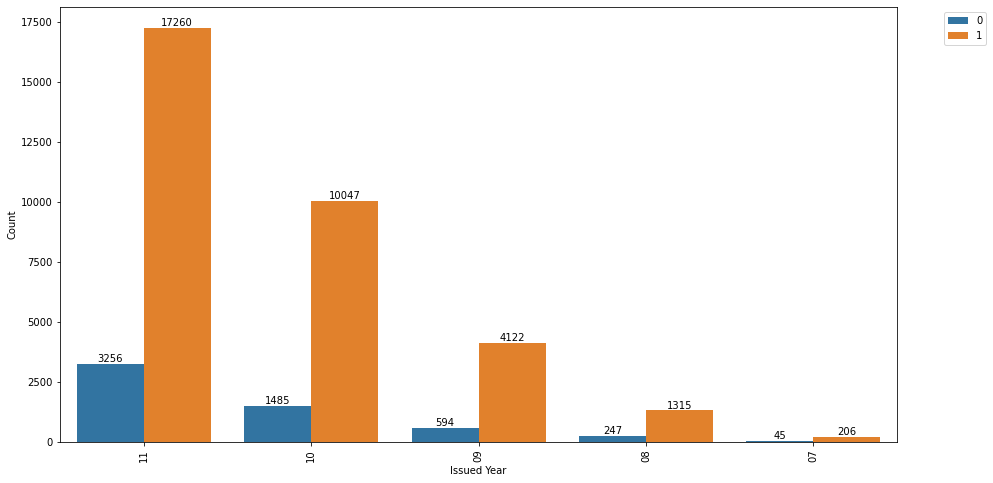

In [79]:
plt.figure(figsize=(15,8))
ax = sns.countplot("issue_year", data=filtered_df, hue=filtered_df['loan_status'])
plt.xlabel("Issued Year")
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

#### Observation from the above chart: Number of Loans approved increasing every year. Pecentage of charged off loan is around 15% for last three years.

### Univariate Analysis 
#### 1) addr_state

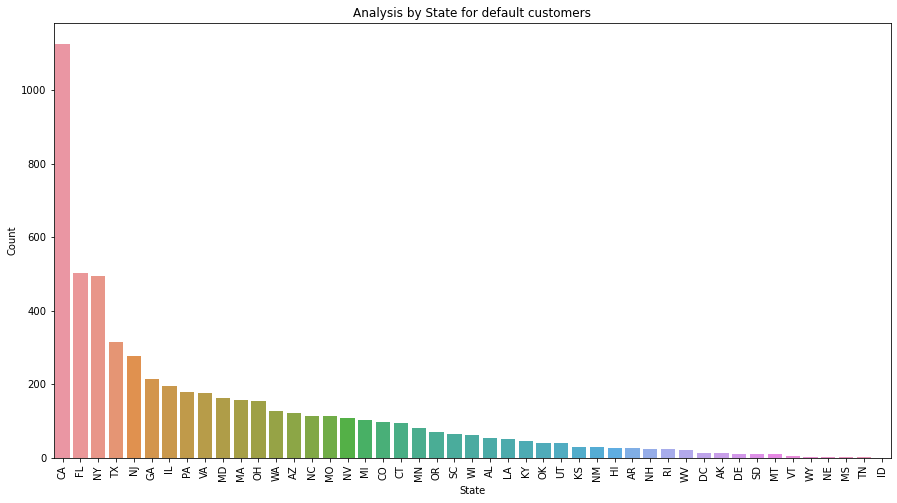

In [60]:
plt.figure(figsize=(15,8))
sns.countplot("addr_state", data=filtered_df[filtered_df['loan_status']== 0], 
              order = filtered_df[filtered_df['loan_status']== 0]["addr_state"].value_counts().index)
plt.xlabel("State")
plt.ylabel("Count")
plt.title("Analysis by State for default customers")
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: Going by the absolute numbers most of the defaults are from state of California residents.

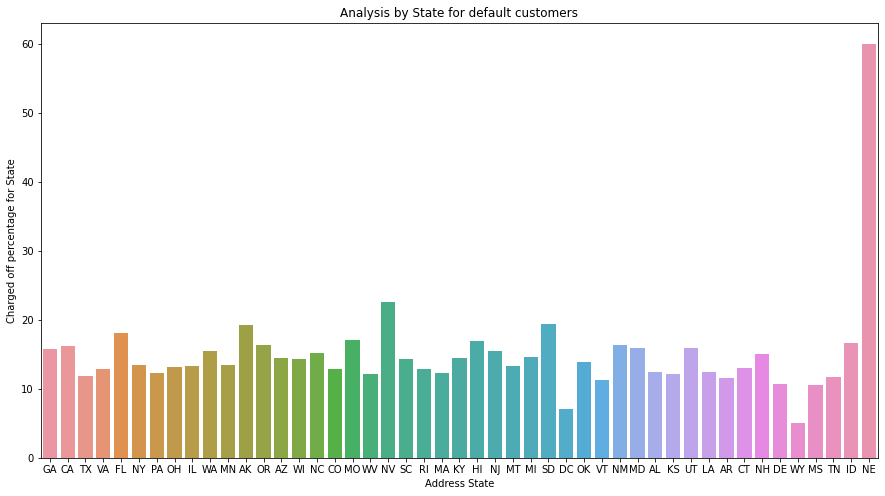

In [61]:
plt.figure(figsize=(15,8))
sns.barplot(x="addr_state", y="addr_state_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Address State")
plt.ylabel("Charged off percentage for State")
plt.title("Analysis by State for default customers")
plt.show()

#### Observation from the above chart: Going by the percentage of default customers, Nebraska has the highest rate of default (~ 60%)

#### 2) Term

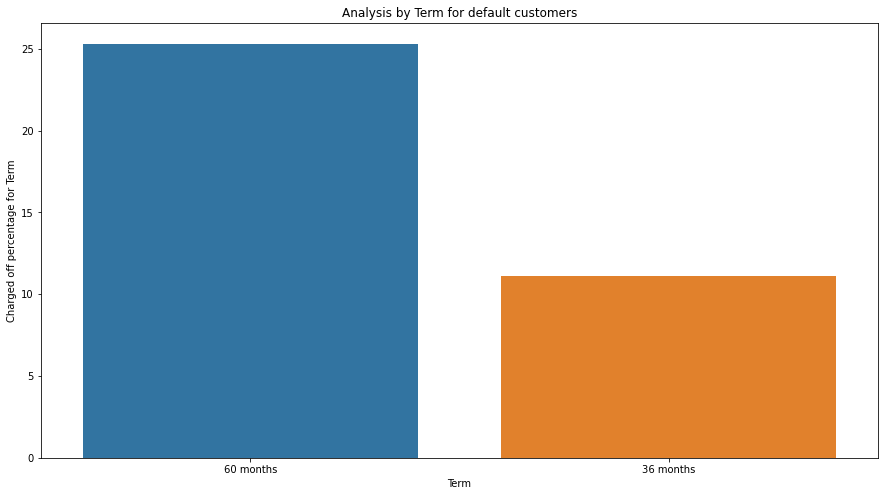

In [62]:
plt.figure(figsize=(15,8))
sns.barplot(x="term", y="term_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Term")
plt.ylabel("Charged off percentage for Term")
plt.title("Analysis by Term for default customers")
plt.show()

#### Observation from the above chart: Percentage of defaults in loans having 60 months term is almost double of 36 months term.

#### 3) Purpose

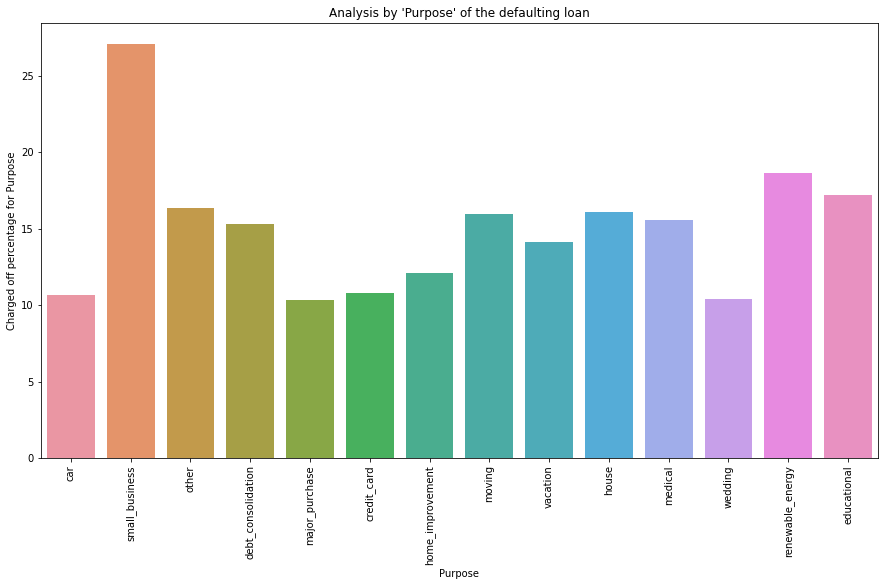

In [81]:
plt.figure(figsize=(15,8))
sns.barplot(x="purpose", y="purpose_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Purpose")
plt.ylabel("Charged off percentage for Purpose")
plt.title("Analysis by 'Purpose' of the defaulting loan")
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: Going by the purpose of the loan, default in `small business` loans is highest followed by loans taken for 'renewable energy'.

#### 4) Home_ownership

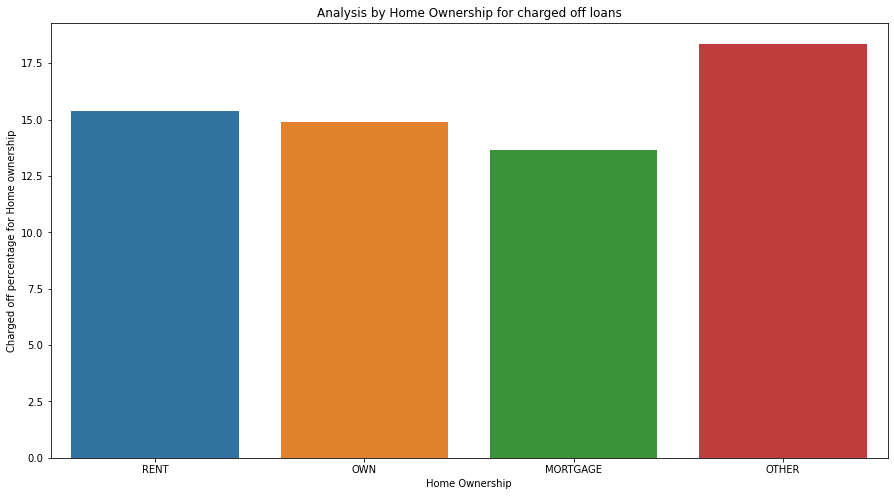

In [80]:
plt.figure(figsize=(15,8))
sns.barplot(x="home_ownership", y="home_ownership_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Home Ownership")
plt.ylabel("Charged off percentage for Home ownership")
plt.title("Analysis by Home Ownership for charged off loans")
plt.show()

#### Observation from the above chart: Customers who have a mortgge loan are least likely to default. 
#### Largest percentage of loan defaults are from customers whose home_ownership category is `Other`

#### 5) Grade

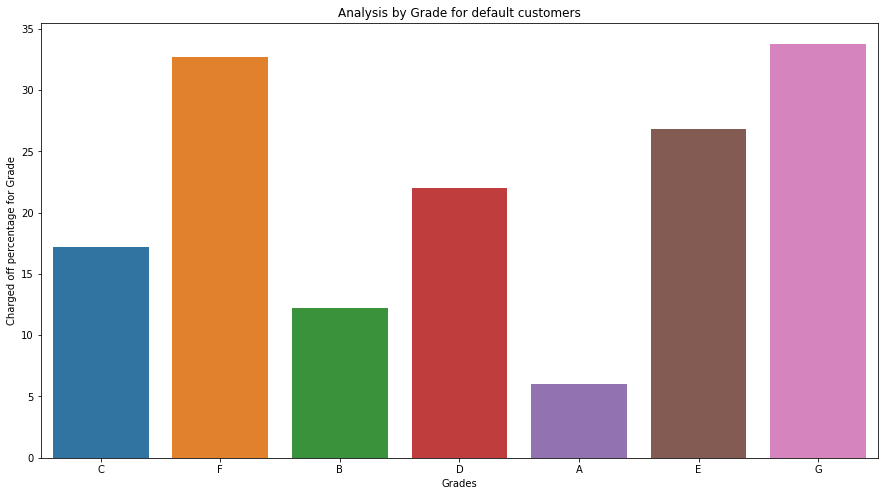

In [65]:
plt.figure(figsize=(15,8))
sns.barplot(x="grade", y="grade_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.ylabel("Charged off percentage for Grade")
plt.xlabel("Grades")
plt.title("Analysis by Grade for default customers")
plt.show()

#### Observation from the above chart: Larger percentage of default is in loan category gradeg as  `G` and `F`

#### issue_year (derived variable)

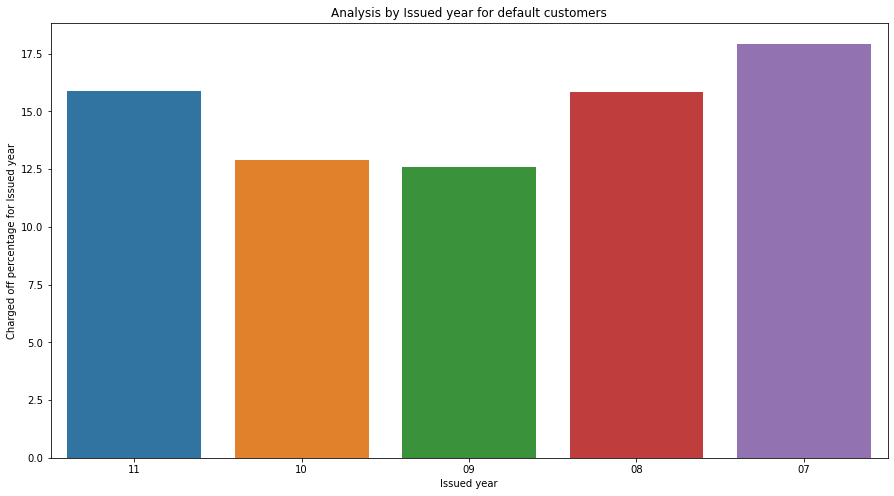

In [66]:
plt.figure(figsize=(15,8))
sns.barplot(x="issue_year", y="issue_year_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Issued year")
plt.ylabel("Charged off percentage for Issued year")
plt.title("Analysis by Issued year for default customers")
plt.show()

#### Observation from the above chart: Largest percentage of defaults happend in loans issued in year 2007

#### 6) emp_length

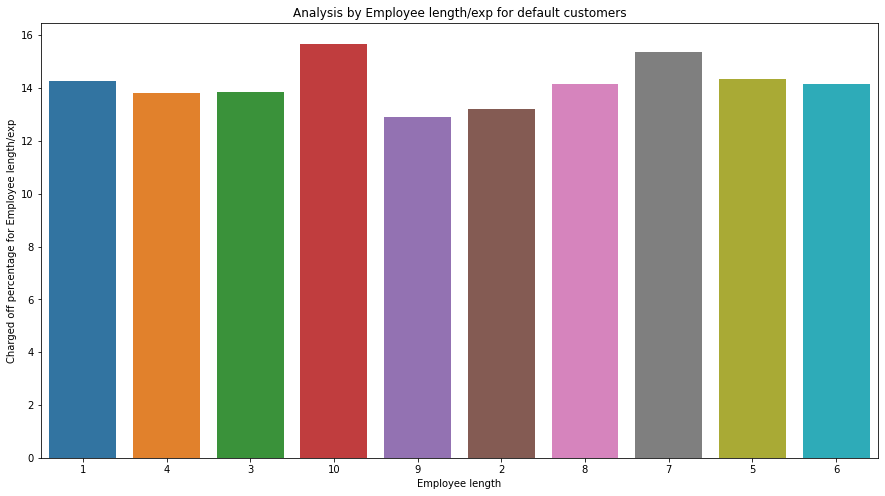

In [67]:
plt.figure(figsize=(15,8))
sns.barplot(x="emp_length", y="emp_length_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Employee length")
plt.ylabel("Charged off percentage for Employee length/exp")
plt.title("Analysis by Employee length/exp for default customers")
plt.show()

#### Observation from the above chart: It appers large percentage of loan default customers have work experiance of 10+ years. Also, there is a dip in defaults at work experience of 9 years. Hence, it wil be better to conslude that loan default is not related to or very weakly co-related to employee length.

#### 7) pub_rec_bankruptcies

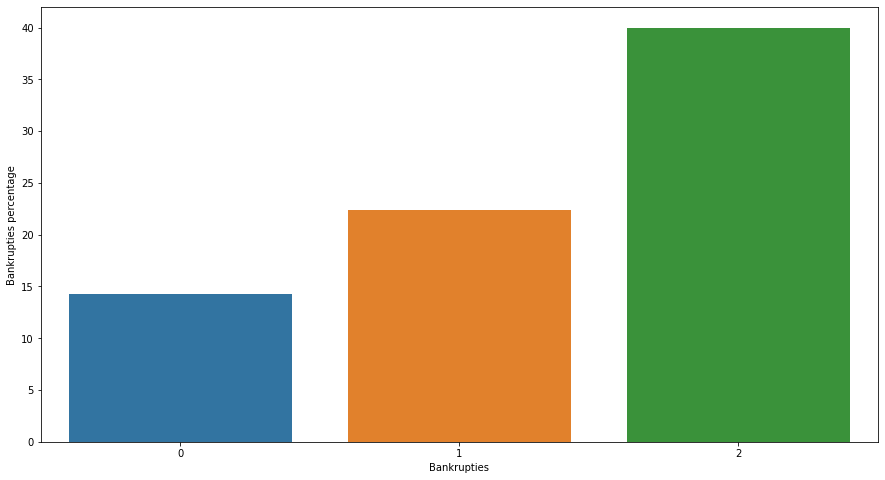

In [68]:
plt.figure(figsize=(15,8))
sns.barplot(x="pub_rec_bankruptcies", y="pub_rec_bankruptcies_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Bankrupties")
plt.ylabel("Bankrupties percentage")
plt.show()

#### Observation from the above chart: Approximate 40% of default customers have two public bankrupt records.

#### 8) Annual Income

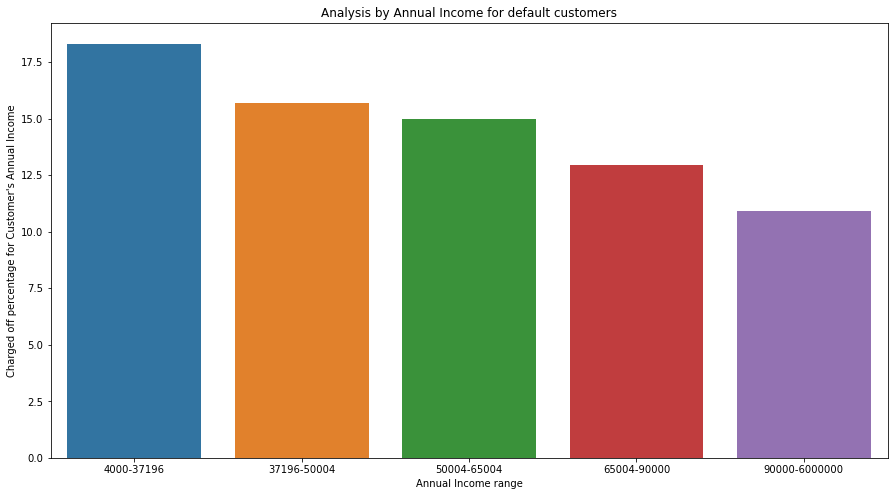

In [69]:
plt.figure(figsize=(15,8))
sns.barplot(x="annual_inc_range", y="annual_inc_range_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Annual Income range")
plt.ylabel("Charged off percentage for Customer's Annual Income")
plt.title("Analysis by Annual Income for default customers")
plt.show()

#### Observation from the above chart: Large percentage of loan default is from customer's whose annual income falls between 4K and 37K

#### 9) Interest rate

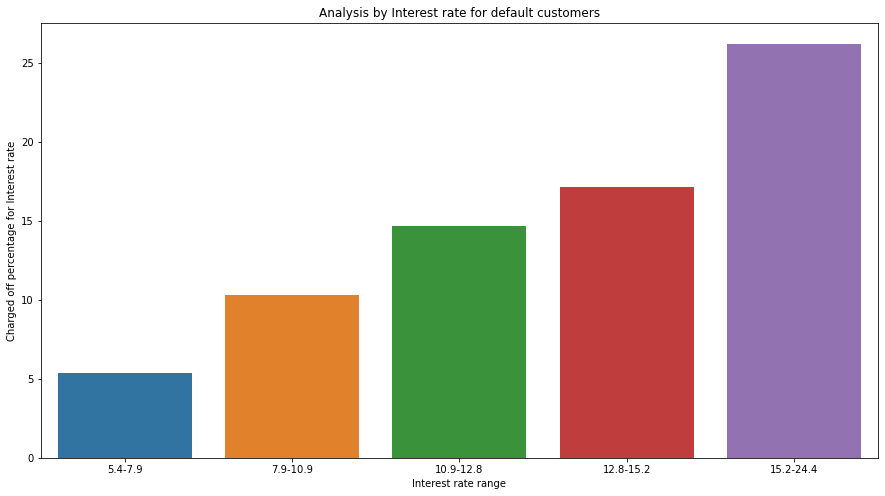

In [70]:
plt.figure(figsize=(15,8))
sns.barplot(x="int_rate_range", y="int_rate_range_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Interest rate range")
plt.ylabel("Charged off percentage for Interest rate")
plt.title("Analysis by Interest rate for default customers")
plt.show()

#### Observation from the above chart: Larger percentage of default customer's loan interest rate was between 15% to 24%

#### 10) Loan amount

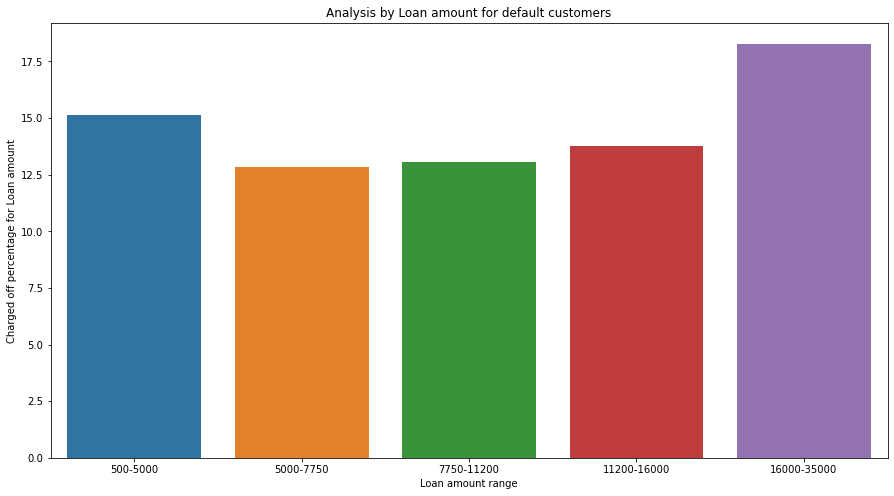

In [71]:
plt.figure(figsize=(15,8))
sns.barplot(x="loan_amnt_range", y="loan_amnt_range_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("Loan amount range")
plt.ylabel("Charged off percentage for Loan amount")
plt.title("Analysis by Loan amount for default customers")
plt.show()

#### Observation from the above chart: Large percentage of default customer's loan amount falls between 16k to 35k.

#### 11) Verification status

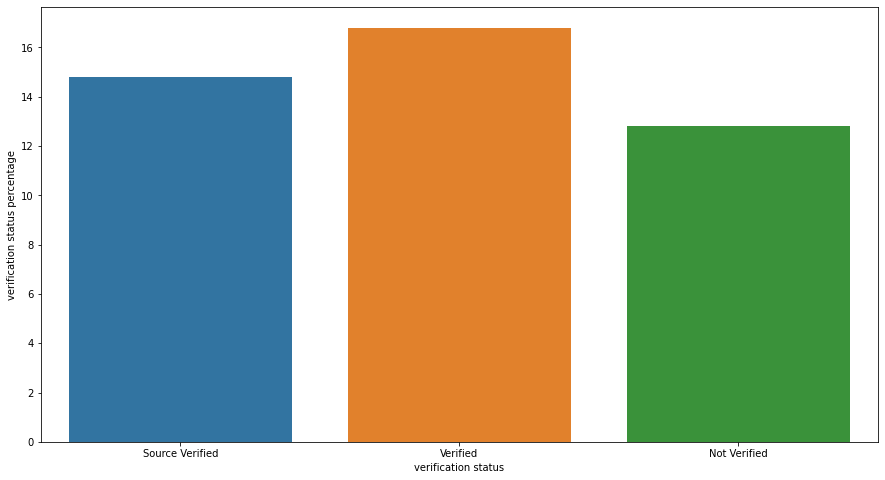

In [72]:
plt.figure(figsize=(15,8))
sns.barplot(x="verification_status", y="verification_status_chargedoff_perc", data=filtered_df[filtered_df["loan_status"] == 0])
plt.xlabel("verification status")
plt.ylabel("verification status percentage")
plt.show()

#### Observation from above chart: Loans whose source of income was verified have defaulted more that the 'Not Verified' customers. One explanation could be that customers who were considered safe were left unverified. 

### Multivariate Analysis 
#### 1) loan amount, home_ownership and loan status

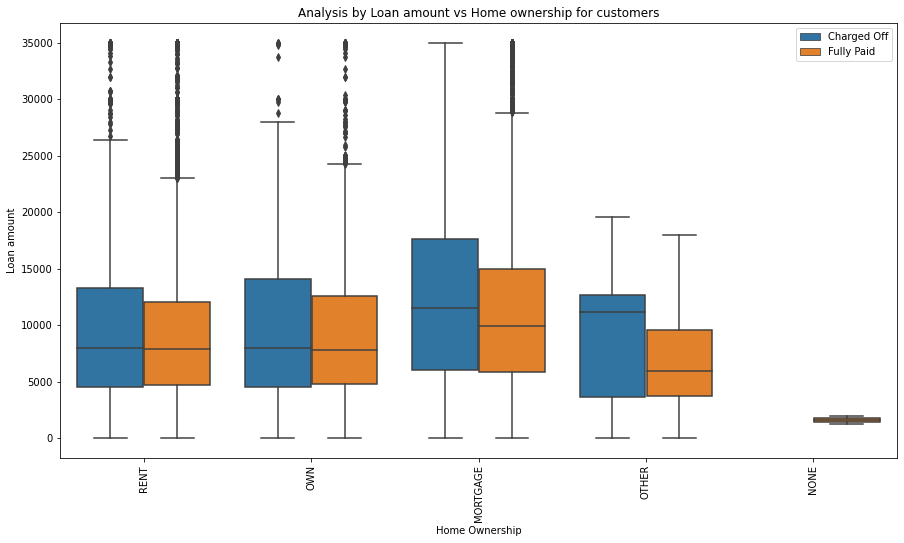

In [73]:
plt.figure(figsize=(15,8))
sns.boxplot(y="loan_amnt", x="home_ownership", data=filtered_df, hue=filtered_df.loan_status)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
L=plt.legend()
# print(L.get_texts()[0]) 0=>Charged Off
# print(L.get_texts()[1]) 1=>Fully Paid
plt.xlabel("Home Ownership")
plt.ylabel("Loan amount")
plt.title("Analysis by Loan amount vs Home ownership for customers")
L.get_texts()[0].set_text('Charged Off')
L.get_texts()[1].set_text('Fully Paid')
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: In the loan defaulted customers, customers whose home_ownership is OTHER have median of defaulted loans around 11000.

#### 2) Loan amount, purpose and loan status

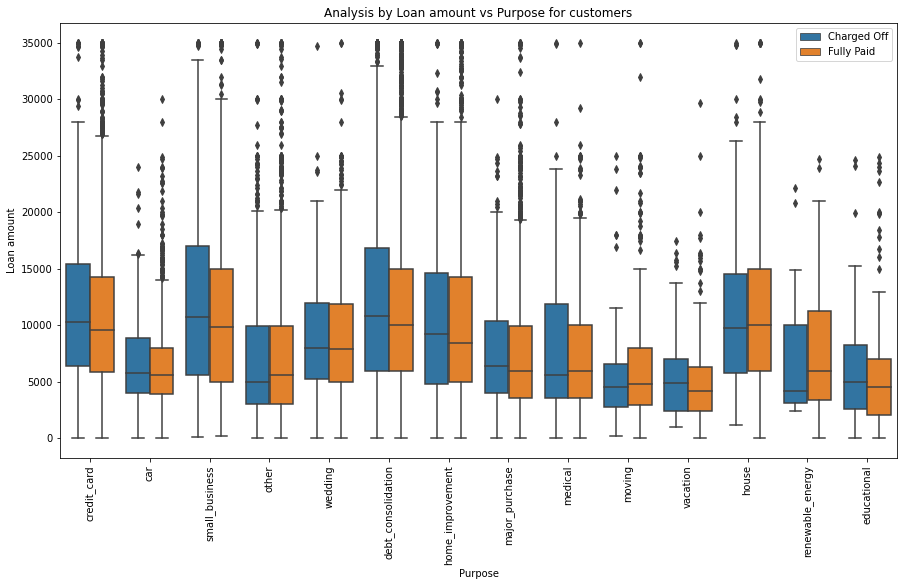

In [74]:
plt.figure(figsize=(15,8))
sns.boxplot(y="loan_amnt", x="purpose", data=filtered_df, hue=filtered_df.loan_status)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
L=plt.legend()
L.get_texts()[0].set_text('Charged Off')
L.get_texts()[1].set_text('Fully Paid')
plt.xlabel("Purpose")
plt.ylabel("Loan amount")
plt.title("Analysis by Loan amount vs Purpose for customers")
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: Customers whose purpose of loan is `small_business` had large ticket loans as compared to other categories. other than loan purpose of type 'home'.

#### 3) Annual income, purpose and loan status

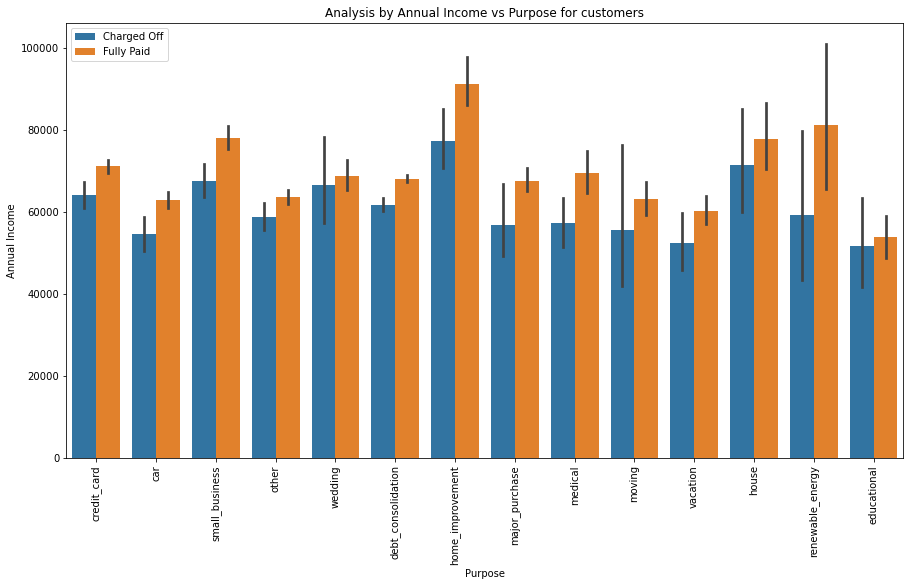

In [75]:
plt.figure(figsize=(15,8))
sns.barplot(y="annual_inc", x="purpose", data=filtered_df, hue=filtered_df.loan_status)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
L=plt.legend()
L.get_texts()[0].set_text('Charged Off')
L.get_texts()[1].set_text('Fully Paid')
plt.xlabel("Purpose")
plt.ylabel("Annual Income")
plt.title("Analysis by Annual Income vs Purpose for customers")
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: In default customers, Customers with more annual income took loan for home_improvement. But wrt to loan default, there is no pattern.

#### 4) Interest rate, purpose and loan status

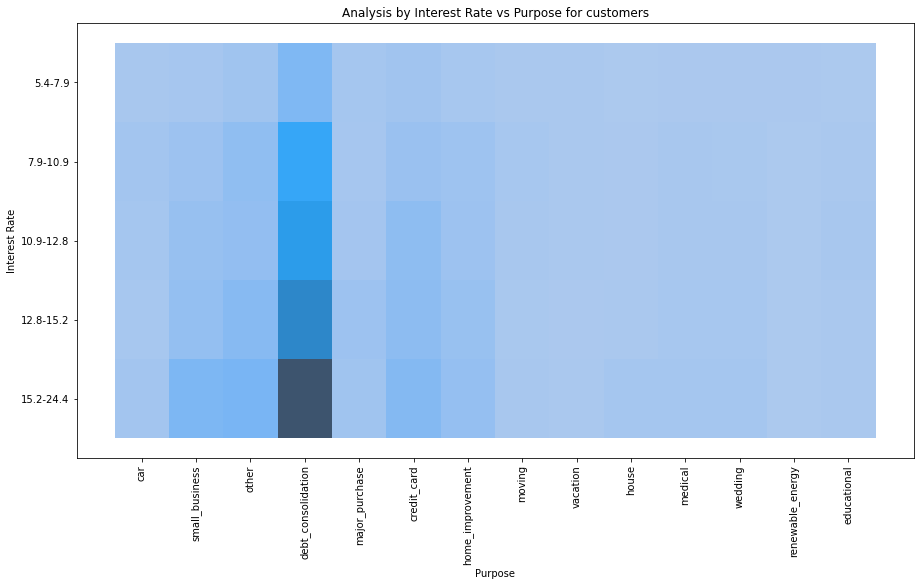

In [76]:
plt.figure(figsize=(15,8))
sns.histplot(y="int_rate_range", x="purpose", data=filtered_df[filtered_df["loan_status"]==0])
plt.xlabel("Purpose")
plt.ylabel("Interest Rate")
plt.title("Analysis by Interest Rate vs Purpose for customers")
plt.xticks(rotation=90)
plt.show()

#### Observation from the above chart: Customers who have taken more loans with high interest rate for `debt consolidation` have high default rate.

### 5) loan amount, grade and loan status

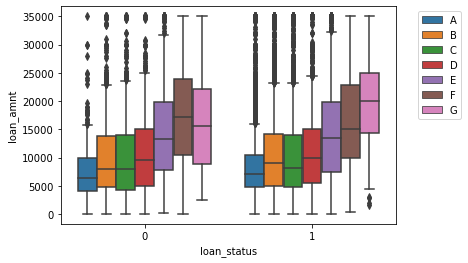

In [77]:
sns.boxplot(x = filtered_df.loan_status, y = filtered_df.loan_amnt, hue = filtered_df.grade, hue_order=['A','B','C','D','E','F','G'], whis = 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

Observation: Grade F loans are defaulting at the higher loan amounts ,charged off loans median = 18000, while fully paid loans have the median of approx 15000.
Median of charged off loans for remaining grades is either same or lower than the median of fully paid off loans.

## Correlation diagram

In [83]:
corr_df = filtered_df.loc[:,['loan_amnt', 'int_rate','installment','annual_inc', 'loan_status', 'dti', 'mths_since_last_delinq','pub_rec_bankruptcies']]

In [84]:
corr_df.corr()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,mths_since_last_delinq,pub_rec_bankruptcies
loan_amnt,1.000000,0.297473,0.905464,0.251981,-0.037781,0.070663,-0.043657,-0.036327
int_rate,0.297473,1.000000,0.277203,0.048899,-0.211390,0.110913,0.166574,0.084016
installment,0.905464,0.277203,1.000000,0.267842,-0.027153,0.052038,-0.028493,-0.033038
annual_inc,0.251981,0.048899,0.267842,1.000000,0.040867,-0.121530,0.018701,-0.015955
loan_status,-0.037781,-0.211390,-0.027153,0.040867,1.000000,-0.045078,-0.020027,-0.046989
dti,0.070663,0.110913,0.052038,-0.121530,-0.045078,1.000000,-0.015231,0.007315
mths_since_last_delinq,-0.043657,0.166574,-0.028493,0.018701,-0.020027,-0.015231,1.000000,0.023936
pub_rec_bankruptcies,-0.036327,0.084016,-0.033038,-0.015955,-0.046989,0.007315,0.023936,1.000000


#### Observation from above correlation diagram: No strongly correlated relationships were found except one loan_amnt/installment.

# Conclusions drawn from the study:

- Largest percentage of defaults happend in loans issued in year 2007. Number of Loans approved are increasing every year. Pecentage of charged off loans is stagnant around 15% for last three years.
- Going by the percentage of default customers, Nebraska has the highest rate of default (~ 60%).

Conclusions from Customer attributes:
- Customers who have a mortgge loan are least likely to default.
- Customers who have taken more loans with high interest rate for debt consolidation have high default rate.
- Largest percentage of loan defaults are from customers whose home_ownership category is Other.
- Large percentage of loan default is from customer's whose annual income falls between 4k and 37k    
- It appers large percentage of loan default customers have work experiance of 10+ years. Also, there is a dip in defaults at work experience of 9 years. Hence, it wil be better to conslude that loan default is not related to or very weakly co-related to employee length.

Conclusions for Loan attributes:
- Percentage of defaults in loans having 60 months term is almost double of 36 months term. Club should negotiate for smaller term repayments for its loan.
- Going by the purpose of the loan, default in small business loans is highest followed by loans taken for 'renewable energy'.
- Approximate 40% of default customers have two public bankrupt records.

Conclusions from loan application grading:
- Larger percentage of default is in loan category gradeg as G and F
- Grade F loans are defaulting at the higher loan amounts ,charged off loans median = 18000, while fully paid loans have the median of approx 15000. Median of charged off loans for remaining grades is either same or lower than the median of fully paid off loans.
- Larger percentage of default customer's loan interest rate was between 15% to 24%
- Customers whose purpose of loan is small_business had large ticket loans as compared to other categories. other than loan purpose of type 'home'.
